In [1]:
from datetime import time

import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

import sys
sys.path.append('..')

from tools.generate import predict_t0, photonsim_differentiable_get_rays
from tools.generate import generate_random_cone_vectors, normalize, photonsim_differentiable_get_rays
from tools.simulation import create_photonsim_siren_grid
from inference import SIRENPredictor
from pathlib import Path

import jax
import jax.numpy as jnp
from jax import random

In [2]:
from tools.utils import unpack_t0_params

In [3]:
model_base_path = Path('../notebooks/output/photonsim_siren_training/trained_model/photonsim_siren')
photonsim_predictor = SIRENPredictor(model_base_path)
table_data = create_photonsim_siren_grid(photonsim_predictor, 500)

# Set up simulation parameters (same as original)
origin = jnp.array([0.5, 0.0, -0.5])
direction = jnp.array([1.0, -1.0, 0.2])
Nphot = 5_000_000
key = random.PRNGKey(0)
energy = 500
model_params = photonsim_predictor.params

In [4]:
ray_vectors, ray_origins, photon_weights = photonsim_differentiable_get_rays(origin, direction, energy, Nphot, table_data, model_params, key)
distances = jnp.linalg.norm(ray_origins, axis=1)

In [5]:

t0_params = unpack_t0_params()
predict_t0_vectorized = jax.vmap(predict_t0, in_axes=(0, None, None, None, None, None, None, None, None))
baseline_slope, baseline_intercept, A_slope, A_intercept, B_slope, B_intercept, offset = t0_params
t0 = predict_t0_vectorized(distances, energy, baseline_slope, baseline_intercept, A_slope, A_intercept, B_slope, B_intercept, offset)


(array([299723., 366636., 407405., 449916., 487749., 535076., 587079.,
        644620., 698072., 523724.]),
 array([0.00455856, 0.00518755, 0.00581653, 0.00644551, 0.0070745 ,
        0.00770348, 0.00833246, 0.00896145, 0.00959043, 0.01021941,
        0.0108484 ]),
 <BarContainer object of 10 artists>)

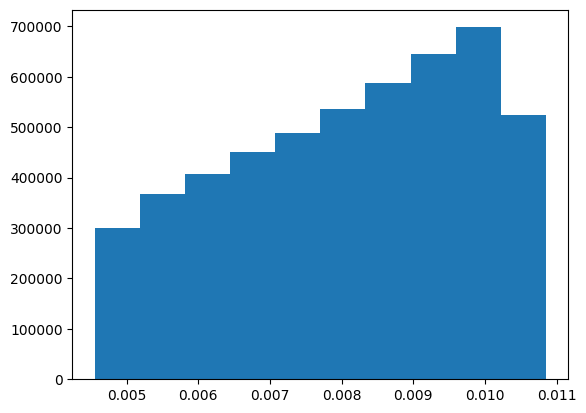

In [6]:
import matplotlib.pyplot as plt

plt.hist(t0)

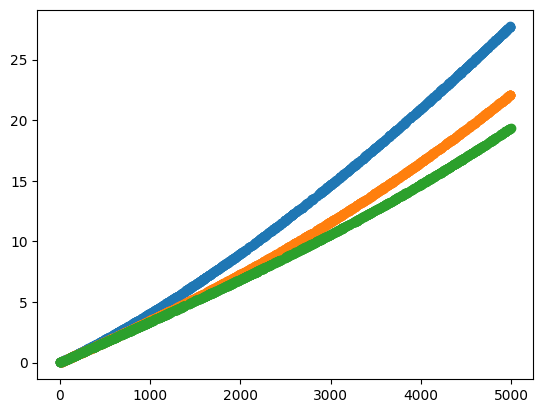

In [7]:
import numpy as np

for energy in [200,400,600]:
    distances = np.random.uniform(0, 5000, 1000)
    t0 = predict_t0_vectorized(distances, energy, baseline_slope, baseline_intercept, A_slope, A_intercept, B_slope, B_intercept, offset)
    _ = plt.scatter(distances, t0)

In [14]:
from tools.propagate import create_photon_propagator
from tools.geometry import generate_detector
from tools.utils import load_single_event, save_single_event, generate_random_params
from tools.losses import compute_loss_with_time
from tools.simulation import setup_event_simulator

default_json_filename = '../config/HK_geom_config.json'

detector = generate_detector(default_json_filename)
detector_points = jnp.array(detector.all_points)
detector_radius = detector.S_radius
NUM_DETECTORS = len(detector_points)
Nphot = 5_000_000

In [25]:
simulate_event = setup_event_simulator(default_json_filename, Nphot, K=5, temperature=0.05)

In [26]:
from tools.utils import generate_random_params

# Generate and save a single event
key = jax.random.PRNGKey(71900)

#trk_params = generate_random_params(key)

trk_params = (jnp.array(500.0, dtype=jnp.float32),
 jnp.array([0.0, 0.0, 0.0], dtype=jnp.float32), 
 jnp.array([1.5708, 0.0], dtype=jnp.float32))

detector_params = (
    jnp.array(100),       # scatter_length
    jnp.array(0.05),         # reflection_rate
    jnp.array(100000.),         # absorption_length
    jnp.array(0.001)        # gumbel_softmax_temp
)


single_event_data = jax.lax.stop_gradient(simulate_event(trk_params, detector_params, key))
#save_single_event(single_event_data, trk_params, detector_params, filename='../events/test_event_data.h5', calibration_mode=False)

(array([ 291.,  339.,  420.,  621.,  390.,  266.,  279.,  263.,  329.,
         485.,  861., 1069., 1294., 1362., 1398., 1400., 1386., 1350.,
        1244., 1125.,  962.,  810.,  556.,  412.,  334.,  202.,  104.,
          58.,   34.,    6.]),
 array([ 0.        ,  2.20888257,  4.41776514,  6.62664795,  8.83553028,
        11.04441261, 13.2532959 , 15.46217823, 17.67106056, 19.87994385,
        22.08882523, 24.29770851, 26.5065918 , 28.71547318, 30.92435646,
        33.13323975, 35.34212112, 37.5510025 , 39.7598877 , 41.96876907,
        44.17765045, 46.38653564, 48.59541702, 50.8042984 , 53.01318359,
        55.22206497, 57.43094635, 59.63982773, 61.84871292, 64.0575943 ,
        66.26647949]),
 <BarContainer object of 30 artists>)

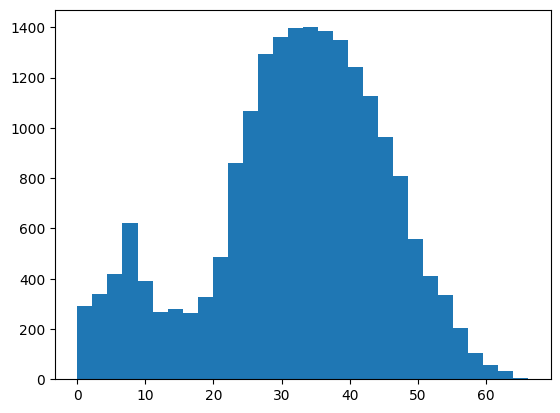

In [30]:
plt.hist(single_event_data[1],bins=30)

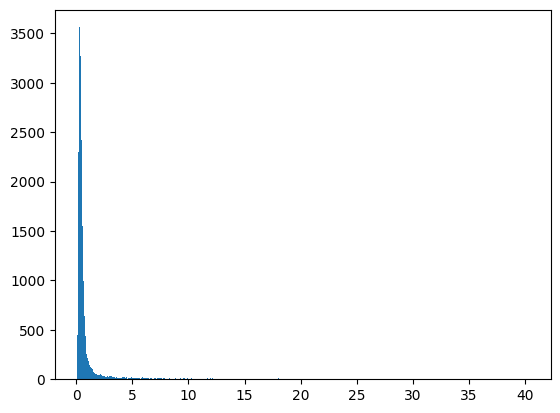

In [34]:
_ = plt.hist(single_event_data[0], bins=500)

In [28]:
save_single_event(single_event_data, trk_params, detector_params, filename='../events/test_event_data.h5', calibration_mode=False)

'../events/test_event_data.h5'

Particle Parameters:
  Energy: 500.00 MeV
  Position: [0.00, 0.00, 0.00] m
  Direction angles: theta=1.57 rad, phi=0.00 rad
  Direction vector: [1.00, 0.00, -0.00]
Detector Parameters:
────────────────────
Scatter Length: 100.00 m
Reflection Rate: 0.05
Absorption Length: 100000.00 m
Simulation Temperature for Gumbel-Softmax: 0.0010
────────────────────


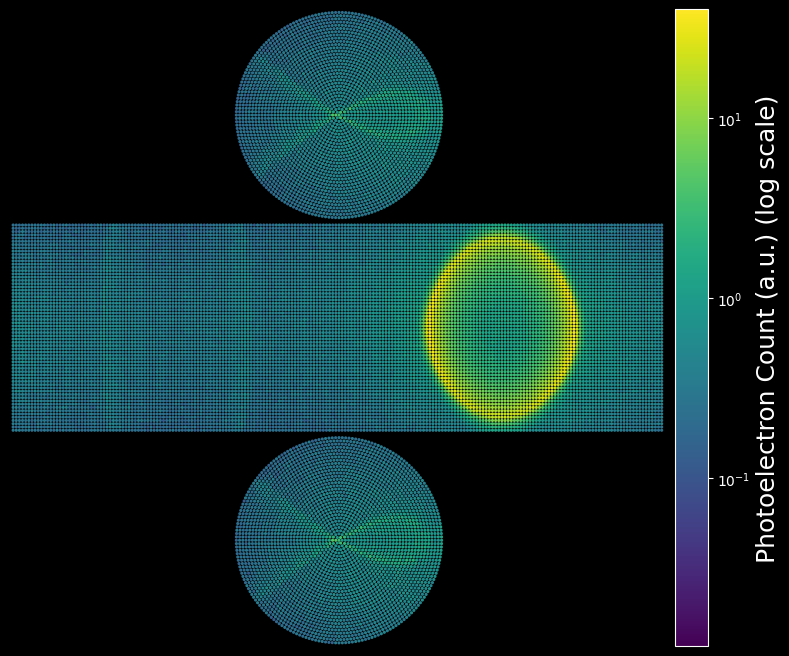

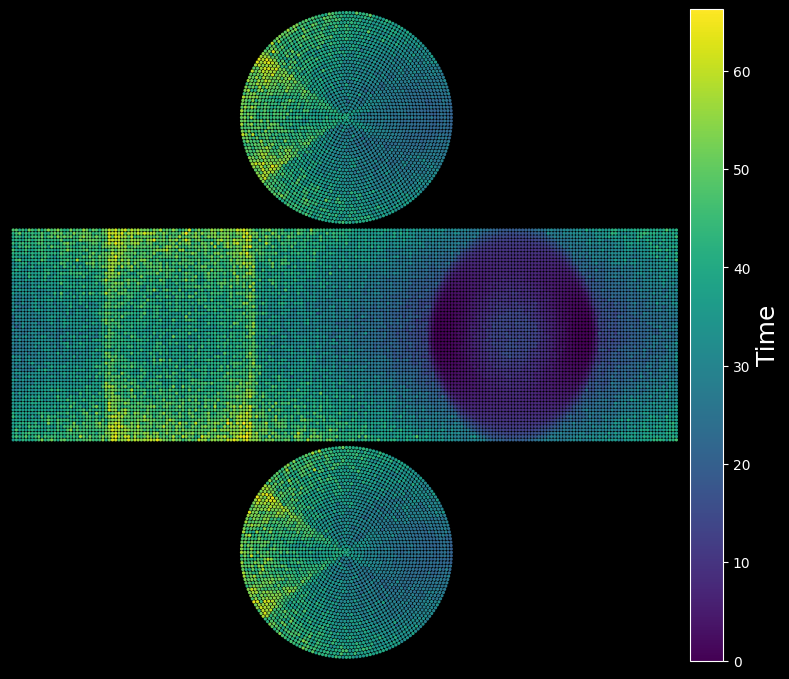

In [29]:
from tools.visualization import create_detector_display
from tools.utils import load_single_event, save_single_event, full_to_sparse, sparse_to_full, print_particle_params, print_detector_params

event_location = '../events/test_event_data.h5'

figures_dir = Path('figures')
figures_dir.mkdir(parents=True, exist_ok=True)

loaded_trk_params, loaded_detector_params, loaded_indices, loaded_charges, loaded_times= load_single_event(event_location, NUM_DETECTORS, calibration_mode=False)
print_particle_params(loaded_trk_params), print_detector_params(loaded_detector_params)

detector_display = create_detector_display(default_json_filename)
detector_display(loaded_indices, loaded_charges, loaded_times, file_name='figures/event_display_charge.png', plot_time=False, log_scale=True)
detector_display(loaded_indices, loaded_charges, loaded_times, file_name='figures/event_display_time.png', plot_time=True)